#Resolución EDP

# Modelo de deformación de viga en voladizo 🏗️

Consideramos la ecuación de Euler-Bernoulli para una viga delgada sometida a carga distribuida:
$$
EI \frac{d^4 w}{dx^4} = q(x),
$$
donde $w(x)$ es la deflexión, $EI$ la rigidez a la flexión y $q(x)$ la carga (constante: $q(x) = q_0$).

Las condiciones de frontera para una viga en voladizo de longitud \(L\) son:
$$
w(0) = w'(0) = 0, \quad w''(L) = w'''(L) = 0.
$$

Para resolver esta EDO se comparará la solución exacta:
$$ w(x) = \frac{q_0}{24EI} \, x^2 (x^2 - 4Lx + 6L^2) $$
y la solución aproximada por la **PINN (Physics-Informed Neural Network)**.

Se presentan visualizaciones de la deflexión, la comparación entre ambas soluciones y una animación ilustrando la deformación de la viga bajo carga.

A continuación, definimos el código utilizando *Pytorch*:

In [72]:
# Importar librerias
import numpy as np                 # Manejo de vectores y matrices (arrays)
import torch                       # Biblioteca principal para cálculo tensorial y redes neuronales
import torch.nn as nn              # Componentes para construir redes neuronales (capas, activaciones)
import torch.optim as optim        # Algoritmos de optimización para ajustar parámetros de la red
import torch.nn.init as init       # Métodos para inicializar pesos de redes neuronales
import torch.autograd as grad      # Cálculo automático de derivadas (gradientes)
import matplotlib.pyplot as plt    # Herramientas para visualización gráfica de resultados
import time                        # Funciones para medir tiempos de ejecución
import math                        # Funciones matemáticas elementales (trigonometría, exponenciales, etc.)
import torch.nn.functional as F    # Funciones matemáticas sin parámetros para redes (activaciones, pérdidas)

In [73]:
# Semilla fijada
torch.manual_seed(1234)

### Parámetros del modelo:

In [74]:
# Datos
L = 6.0             # Longitud de la viga (m)
EI = 1.0            # Rigidez a la flexión (constante)
q0_min = 1.0        # Carga mínima q0 (N/m)
q0_max = 10.0       # Carga máxima q0 (N/m)

# Parámetros para generación de datos
Nf = 1000           # Número de puntos para evaluar el residuo (error)
print_freq = 2000   # Frecuencia para imprimir información durante el entrenamiento

# Para discretización en x (espacio)
n_points = 4000     # Número de puntos para evaluar la solución exacta en el espacio

In [75]:
def residual(x_q0, model, EI):
    """
    Calcula el residuo del PDE de la viga:
    EI * w''''(x) = q0

    x_q0: tensor con columnas [x, q0]
    model: la red neuronal que predice w
    EI: rigidez a la flexión (constante)

    Retorna: residuo del PDE en los puntos x_q0
    """
    x_q0.requires_grad_(True)    # Necesario para calcular derivadas

    w = model(x_q0)              # Predicción de la red

    # Derivadas respecto a x (primero seleccionamos x)
    x = x_q0[:, 0].unsqueeze(1)  # solo x
    q0 = x_q0[:, 1].unsqueeze(1) # carga q0 (constante en cada punto)

    # Primera derivada w'
    dw_dx = torch.autograd.grad(w, x_q0, grad_outputs=torch.ones_like(w), create_graph=True)[0][:,0].unsqueeze(1)

    # Segunda derivada w''
    d2w_dx2 = torch.autograd.grad(dw_dx, x_q0, grad_outputs=torch.ones_like(dw_dx), create_graph=True)[0][:,0].unsqueeze(1)

    # Tercera derivada w'''
    d3w_dx3 = torch.autograd.grad(d2w_dx2, x_q0, grad_outputs=torch.ones_like(d2w_dx2), create_graph=True)[0][:,0].unsqueeze(1)

    # Cuarta derivada w''''
    d4w_dx4 = torch.autograd.grad(d3w_dx3, x_q0, grad_outputs=torch.ones_like(d3w_dx3), create_graph=True)[0][:,0].unsqueeze(1)

    # Residuo del PDE
    res = EI * d4w_dx4 + (-q0)  # EI * w'''' - q0 = 0

    return res

In [76]:
# Solución exacta para la deflexión de la viga en voladizo bajo carga constante q0
def exact(x, q0, EI, L):
    """
    Solución exacta para la deflexión de la viga en voladizo con carga uniforme q0
    w(x) = (q0 / 24EI) * x^2 * (x^2 - 4Lx + 6L^2)
    """
    return (q0 / (24 * EI)) * x**2 * (x**2 - 4 * L * x + 6 * L**2)

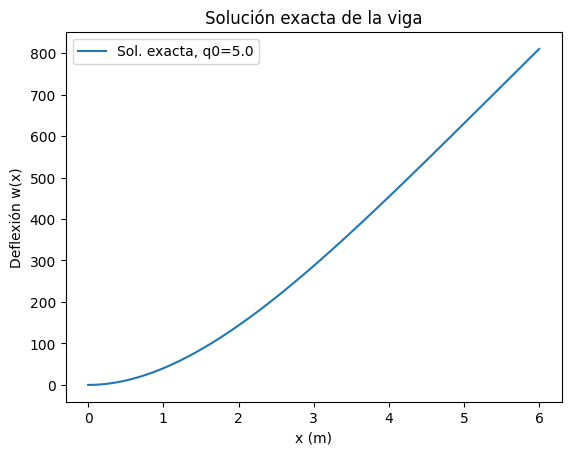

In [77]:
n = 4000
q0 = 5.0  # Ejemplo: carga constante para esta evaluación

h = L / n  # Paso espacial

# Puntos equidistantes en el espacio [0, L]
x_exact = torch.linspace(0, L, n)

# Evaluar la solución exacta con el q0 elegido
y_exact = exact(x_exact, q0, EI, L).detach().numpy()

# Graficar la solución exacta
plt.figure()
plt.plot(x_exact.numpy(), y_exact, label=f'Sol. exacta, q0={q0}')
plt.legend()
plt.title("Solución exacta de la viga")
plt.xlabel('x (m)')
plt.ylabel('Deflexión w(x)')
plt.show()

### Definición red neuronal:

In [78]:
class PINN(nn.Module):     # Clase para la red neuronal PINN

    def __init__(self, input_size, hidden_size, output_size):    # Inicializador

        super(PINN, self).__init__()                             # Inicializador de la clase base nn.Module


        # Definición de las capas de la red neuronal (5 capas lineales)
        #  nn.Linear(input_size, hidden_size)
        #  input_size : cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: cantidad de salidas (neuronas en la capa actual)
        # Capa lineal => salida = Entradas × Pesos + Sesgo

        # Capa 1: Entrada con input_size características, salida con hidden_size características
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Entrada con hidden_size características, salida con hidden_size características
        self.fc3 = nn.Linear(hidden_size, hidden_size)

        # Capa 4: Entrada con hidden_size características, salida con hidden_size características
        self.fc4 = nn.Linear(hidden_size, hidden_size)

        # Capa 5: Entrada con hidden_size características, salida con 1 característica
        self.fc5 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos:
        # 1) Random Initialization
        # Los pesos de las capas se inicializan con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # ó
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # 2) Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica
        # Ayuda a mantener una varianza constante a través de las capas
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.xavier_normal_(self.fc5.weight)


    def forward(self, x_q0):
       # Propagación hacia adelante
       # Método forward:
       # - toma la entrada x
       # - pasa a través de las capas fc1, fc2 y fc3
       # (utiliza la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas)
       x = torch.tanh(self.fc1(x_q0))
       x = torch.tanh(self.fc2(x))
       x = torch.tanh(self.fc3(x))
       x = torch.tanh(self.fc4(x))
       x = self.fc5(x)             # No aplicamos función de activación en la última capa fc3

       return x

### Datos de entrenamiento:

In [79]:
print(x_exact.shape)              # Forma del tensor de posiciones (entrada)
print(y_exact.shape)              # Forma del tensor de valores exactos (salida)

# Selección de todos los puntos (con paso 1)
x = x_exact[::1]
y = y_exact[::1]

# Define el valor de carga q0 (puedes cambiarlo o hacerlo variable luego)
q0_value = 5.0

# Crear un tensor q0 con el mismo tamaño que x, con valor constante q0_value
q0_tensor = torch.full_like(x, q0_value)

# Concatenar para que la entrada sea [x, q0]
input_tensor = torch.cat((x.view(-1,1), q0_tensor.view(-1,1)), dim=1)

# Convertir y a tensor columna
y = torch.Tensor(y).view(-1,1)

print(input_tensor.shape)       # (n_puntos, 2) -> x y q0
print(y.shape)                  # (n_puntos, 1)

torch.Size([4000])
(4000,)
torch.Size([4000, 2])
torch.Size([4000, 1])


In [80]:
# Número (deseado) de datos para el entrenamiento (ajustable)
k = 50

k1 = k+1             # (opcional, si se requiere un punto adicional)
j = math.ceil(n/k)   # Tamaño del paso: espaciado uniforme en los datos originales
print(j)

j = j-1              # Ajuste fino del paso (evita tomar el último punto fuera de rango)

# Selección de subconjunto de datos de entrenamiento a partir del conjunto completo
# Tomamos 1 punto cada 'j' posiciones
x_data = x[::j]      # Posiciones de entrenamiento
y_data = y[::j]      # Valores exactos correspondientes

# Definir q0 para cada punto de entrenamiento (puede ser constante o variable)
q0_value = 5.0
q0_data = torch.full_like(x_data, q0_value)

# Concatenar para formar entradas con dos columnas: [x, q0]
input_data = torch.cat((x_data.view(-1,1), q0_data.view(-1,1)), dim=1)

# Forma de los datos de entrenamiento
input_data.shape, y_data.shape

80


(torch.Size([51, 2]), torch.Size([51, 1]))

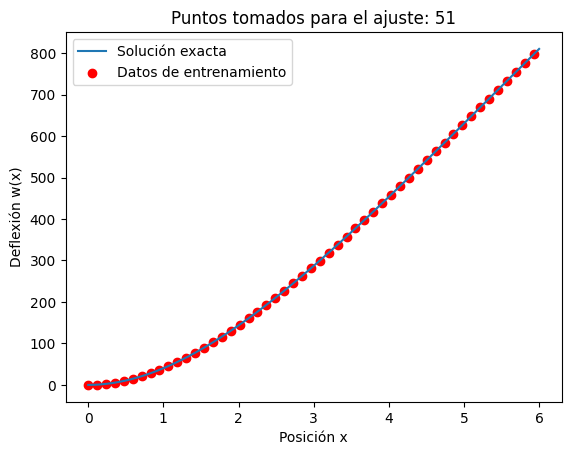

In [81]:
plt.figure()
plt.plot(x, y, label="Solución exacta")
plt.scatter(x_data, y_data, c="red", label="Datos de entrenamiento")
plt.title(f'Puntos tomados para el ajuste: {len(x_data)}')
plt.xlabel("Posición x")
plt.ylabel("Deflexión w(x)")
plt.legend()
plt.show()

In [82]:
# Función de entrenamiento
def train(model, optimizer, loss_fn, input_data, y_data, num_epochs):

  learning_rates = []                             # Lista --> almacena los learning rates en cada iteración/época
  loss_history = []                               # Lista --> almacena la pérdida en cada época

  for epoca in range(num_epochs):                 # Bucle de entrenamiento

    # Calcular las predicciones de la red y las derivadas
    model.train()                                 # Activación del modo de entrenamiento de la red

    y_pred = model(input_data)                    # Predicciones de la red

    # Calcular la pérdida entre predicciones y datos reales
    loss = loss_fn(y_pred, y_data)

    # Optimización
    optimizer.zero_grad()                         # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()                               # Se realiza la retropropagación backward
    optimizer.step()                              # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)

    loss_history.append(loss.item())              # Almacenamiento de la pérdida (error)

    current_lr = optimizer.param_groups[0]['lr']  # Obtiene learning rate actual
    learning_rates.append(current_lr)             # Almacenamiento del learning rate

    if (epoca + 1) % print_freq == 0:
      print(f'Epoch [{epoca+1}/{num_epochs}], Total Loss: {loss.item()}')

  return loss_history, learning_rates, y_pred     # Lista de la pérdida y el lerning rate al final del entrenamiento

In [83]:
# Instancia del modelo y del optimizador

# Creación del modelo con los parámetros definidos
# model = PINN(input_size, hidden_size, output_size)
# Necesitamos como datos de entrada:
# - input_size
# - hidden_size
# - output_size

# Parámetros del modelo
input_size = 2            # Número de entradas de la red
#hidden_size = 11         # Número de neuronas en la capa oculta
hidden_size = 60          # Opciones alternativas del tamaño de la capa oculta
#hidden_size = 200
output_size = 1           # Número de salidas de la red

# Tasa de aprendizaje
learnig_rate = 0.001
# learnig_rate = 0.01

model = PINN(input_size, hidden_size, output_size)
# Definición del optimizador para la actualización de los pesos de la red
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)

# Función de pérdida para calcular el error de la red
loss_fn = nn.MSELoss()

start_time = time.time()   # Tiempo de inicio

# Número de iteraciones:
num_epoch = 40000
#num_epoch = 40000         # Otras opciones
#num_epoch = 30000
#num_epoch = 35000
#num_epoch = 48000
#num_epoch = 22000
#num_epoch =15000
#num_epoch = 10000
#num_epoch = 1000000       # Muchísimas épocas (no recomendable en muchos casos)
#num_epoch = 5000

# Ejemplo: si q0 es constante para todos (cambiar por los valores variables que tengas)
x_data = x_data.view(-1, 1)
q0_data = q0_data.view(-1, 1)    # q0_value es el valor actual o un tensor con valores variables

# Concatenar columnas para formar la entrada con 2 características: t y q0
input_train = torch.cat((x_data, q0_data), dim=1)  # forma [N, 2]

# Entrenamos el modelo utilizando la función de entrenamiento
loss_history, learning_rates, y = train(model, optimizer, loss_fn, input_train, y_data, num_epoch)

end_time = time.time()     # Tiempo de finalización

# Calculamos el tiempo transcurrido durante el entrenamiento
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

Epoch [2000/40000], Total Loss: 102890.03125
Epoch [4000/40000], Total Loss: 74478.375
Epoch [6000/40000], Total Loss: 34800.26171875
Epoch [8000/40000], Total Loss: 17553.787109375
Epoch [10000/40000], Total Loss: 7869.47998046875
Epoch [12000/40000], Total Loss: 2943.142822265625
Epoch [14000/40000], Total Loss: 850.9476928710938
Epoch [16000/40000], Total Loss: 174.35943603515625
Epoch [18000/40000], Total Loss: 22.694839477539062
Epoch [20000/40000], Total Loss: 1.7906057834625244
Epoch [22000/40000], Total Loss: 0.1522916853427887
Epoch [24000/40000], Total Loss: 0.18396389484405518
Epoch [26000/40000], Total Loss: 0.21927927434444427
Epoch [28000/40000], Total Loss: 0.009678170084953308
Epoch [30000/40000], Total Loss: 0.01741129718720913
Epoch [32000/40000], Total Loss: 0.021247901022434235
Epoch [34000/40000], Total Loss: 0.049454834312200546
Epoch [36000/40000], Total Loss: 0.005947537254542112
Epoch [38000/40000], Total Loss: 0.005143956746906042
Epoch [40000/40000], Total Lo

In [84]:
y = model(input_train).detach()

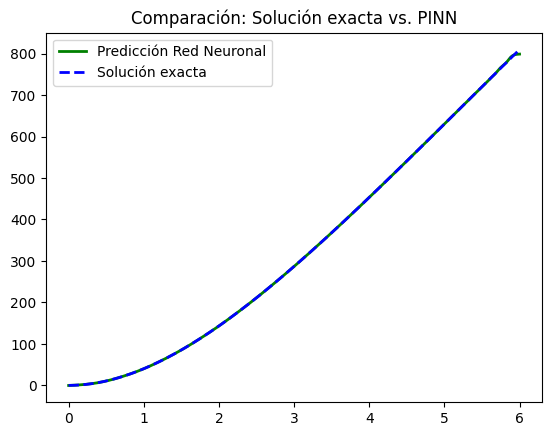

In [85]:
plt.figure()

# Suponiendo que q0 es un escalar
q0_tensor = torch.tensor([[q0]])  # Forma [1, 1]

# Asegurarse de que x es un tensor columna
x = x.view(-1, 1)  # [4000, 1]

# Repetir q0 a lo largo de las filas de x para formar [4000, 1]
q0_all = q0_tensor.repeat(x.shape[0], 1)  # [4000, 1]

# Concatenar x y q0_all --> [4000, 2]
input_all = torch.cat((x, q0_all), dim=1)

# Predicción
with torch.no_grad():
    y_pred = model(input_all)
# Graficar
plt.plot(x.numpy(), y_pred.numpy(), c="green", linewidth=2, label="Predicción Red Neuronal")
plt.plot(x.numpy(), y_exact, c="blue", linewidth=2, linestyle='--', label="Solución exacta")
plt.legend()
plt.title("Comparación: Solución exacta vs. PINN")
plt.show()

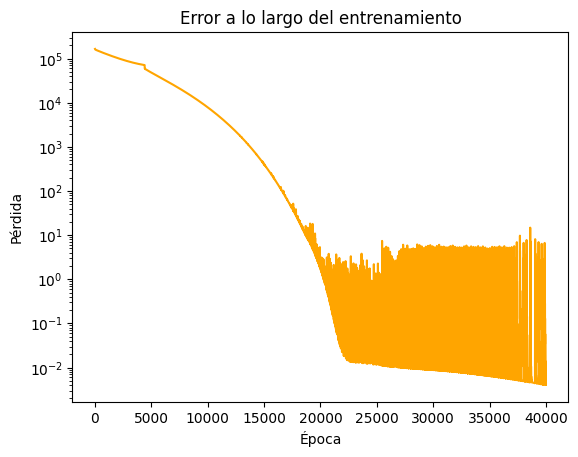

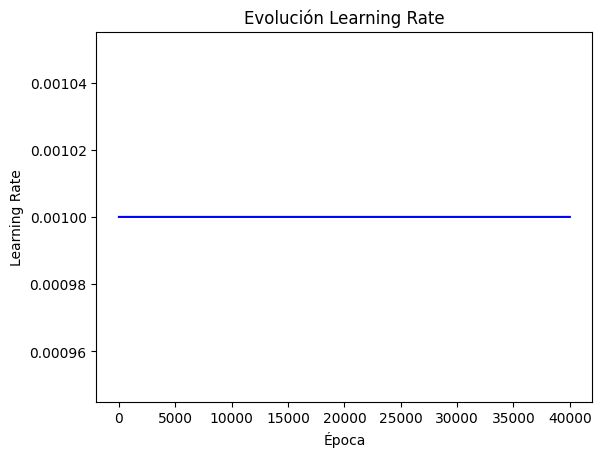

In [86]:
# Figura con dos subgráficas
plt.figure()

# Graficamos la evolución de la pérdida durante el entrenamiento
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Pérdida de entrenamiento', color='orange')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.yscale('log')         # Escala logarítmica para visualizar mejor la evolución
plt.title('Error a lo largo del entrenamiento')
plt.show()


# Graficamos la evolución del learning rate durante el entrenamiento
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='blue')
plt.xlabel('Época')
plt.ylabel('Learning Rate')
plt.title('Evolución Learning Rate')


# Ajustar el diseño y mostrar la gráfica

plt.show()

### Animación:

Animación mostrada arriba y guardada como 'viga_deflexion.mp4'


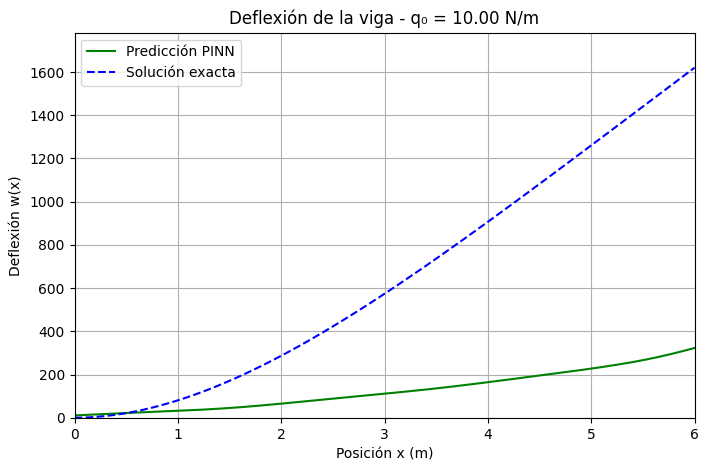

In [89]:
import matplotlib.animation as animation
from IPython.display import HTML

# Rango de valores de q0 para animar (ejemplo de 1 a 10)
q0_values = torch.linspace(q0_min, q0_max, steps=100)

# Asegurarnos que x esté en la forma [N,1]
x_input = x.view(-1, 1)  # x es tensor con posiciones

fig, ax = plt.subplots(figsize=(8,5))
line_pred, = ax.plot([], [], 'g-', label='Predicción PINN')
line_exact, = ax.plot([], [], 'b--', label='Solución exacta')
ax.set_xlim(0, L)
ax.set_xlabel('Posición x (m)')
ax.set_ylabel('Deflexión w(x)')
ax.legend()
ax.grid(True)

def init():
    line_pred.set_data([], [])
    line_exact.set_data([], [])
    return line_pred, line_exact

def update(frame):
    q0_val = q0_values[frame].item()
    q0_tensor = torch.full_like(x_input, q0_val)
    input_all = torch.cat((x_input, q0_tensor), dim=1)

    with torch.no_grad():
        y_pred = model(input_all).detach().numpy().flatten()

    y_ex = exact(x_input.flatten(), q0_val, EI, L).detach().numpy()

    line_pred.set_data(x_input.numpy(), y_pred)
    line_exact.set_data(x_input.numpy(), y_ex)

    ymin = min(y_pred.min(), y_ex.min())
    ymax = max(y_pred.max(), y_ex.max())
    ax.set_ylim(ymin*1.1, ymax*1.1)

    ax.set_title(f'Deflexión de la viga - q₀ = {q0_val:.2f} N/m')
    return line_pred, line_exact

ani = animation.FuncAnimation(fig, update, frames=len(q0_values),
                              init_func=init, blit=True, interval=100, repeat=True)

# Mostrar animación en el notebook usando HTML5 video
html_anim = ani.to_html5_video()
display(HTML(html_anim))

# Si quieres guardar el vídeo (opcional)
ani.save('viga_deflexion.mp4', writer='ffmpeg', fps=30)

# No cerrar la figura antes de mostrar animación
# plt.close(fig)

print("Animación mostrada arriba y guardada como 'viga_deflexion.mp4'")